In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [2]:
sales = pd.read_csv("C:\\Users\\DHRUBAJIT\\Desktop\\AnalyticsVidhya\\Big Mart Sales\\new_sales_csv.csv")
sales.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_type_new
0,FDA15,weights2,Low Fat,low,Dairy,249.8092,OUT049,med,High,Tier 1,Supermarket Type1,3735.1380,other
1,DRC01,weights1,Regular,low,Soft Drinks,48.2692,OUT018,low,High,Tier 2,Supermarket Type2,443.4228,Drinks
2,FDN15,weights1,Low Fat,low,Meat,141.6180,OUT049,med,High,Tier 1,Supermarket Type1,2097.2700,other
3,FDX07,weights1,Regular,low,Fruits and Vegetables,182.0950,OUT010,med,High,Tier 2,Grocery Store,732.3800,other
4,NCD19,weights1,Low Fat,low,Household,53.8614,OUT013,med,High,Tier 2,Supermarket Type1,994.7052,other


In [3]:
#deleting unwanted features 
#also deleted Item_Fat_Content because from hypothesis testing,we found that there is no difference in the means.
sales = sales.drop(['Item_Identifier','Item_Type','Outlet_Identifier','Item_Fat_Content'], axis=1)

In [4]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

encoder_list = ['Item_Weight', 'Item_Visibility',
       'Outlet_Establishment_Year', 'Outlet_Size',
       'Outlet_Location_Type', 'Outlet_Type', 
       'Item_type_new']

for i in encoder_list:
    sales[i] = le.fit_transform(sales[i])

In [5]:
sales = pd.get_dummies(sales, columns=encoder_list)

In [6]:
#avoiding dummy variable trap
sales = sales.drop(['Item_Weight_0','Item_Visibility_0','Outlet_Establishment_Year_0','Outlet_Size_0',
                   'Outlet_Location_Type_0','Outlet_Type_0','Item_type_new_0'], axis=1)

In [7]:
X = sales.drop(['Item_Outlet_Sales'], axis=1)
y = sales.Item_Outlet_Sales

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
sc = StandardScaler()
XX = sc.fit_transform(X)

In [9]:
from sklearn.linear_model import SGDRegressor
from sklearn.feature_selection import SelectFromModel

lsvc = SGDRegressor(penalty="l2").fit(XX, y)
model = SelectFromModel(lsvc, prefit=True)
XXX = model.transform(XX)
print("Original number of features : %d" %XX.shape[1])
print("Selected number of features : %d" %XXX.shape[1])

C:\Users\DHRUBAJIT\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Original number of features : 11
Selected number of features : 4


#### Test dataset

In [10]:
test = pd.read_csv("C:\\Users\\DHRUBAJIT\\Desktop\\AnalyticsVidhya\\Big Mart Sales\\new_testsales_csv.csv")

item_id = test['Item_Identifier']
out_id = test['Outlet_Identifier']

test = test.drop(['Item_Identifier','Item_Type','Outlet_Identifier','Item_Fat_Content'], axis=1)

for i in encoder_list:
    test[i] = le.fit_transform(test[i])
    
test = pd.get_dummies(test, columns=encoder_list)

test = test.drop(['Item_Weight_0','Item_Visibility_0','Outlet_Establishment_Year_0','Outlet_Size_0',
                   'Outlet_Location_Type_0','Outlet_Type_0','Item_type_new_0'], axis=1)

test = sc.fit_transform(test)

In [11]:
test = model.transform(test)

In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

def validation_cross(model, x,y):
    model.fit(x, y)

    #Predict training set:
    pred = model.predict(x)

    #Perform cross-validation:
    cv_score = cross_val_score(model, x, y, cv=10, scoring='neg_mean_squared_error')
    cv_score = np.sqrt(np.abs(cv_score))

    #Print model report:
    print ("\nModel Report")
    print ("RMSE : %.4g" % np.sqrt(mean_squared_error(y.values, pred)))
    print ("CV Score : Mean - %.4g | Std - %.4g" % (np.mean(cv_score),np.std(cv_score)))

### Baseline Model with l2-based feature selection

In [14]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor()
validation_cross(gbr, XXX, y)


Model Report
RMSE : 1052
CV Score : Mean - 1092 | Std - 21.28


#### Model Tuning

In [15]:
# 1. n_estimators

param_test1 = {'n_estimators':range(50,1050,50),
               'learning_rate':[0.001,0.005,0.01,0.05,0.1,0.2],
               'subsample': [0.6,0.7,0.8,0.9,1.0]}
gsearch1 = GridSearchCV(estimator = GradientBoostingRegressor(), param_grid = param_test1, n_jobs=-1, iid=False, cv=3)
gsearch1.fit(XXX,y)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

C:\Users\DHRUBAJIT\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.04413, std: 0.00042, params: {'subsample': 0.6, 'learning_rate': 0.001, 'n_estimators': 50},
  mean: 0.04406, std: 0.00037, params: {'subsample': 0.7, 'learning_rate': 0.001, 'n_estimators': 50},
  mean: 0.04403, std: 0.00032, params: {'subsample': 0.8, 'learning_rate': 0.001, 'n_estimators': 50},
  mean: 0.04400, std: 0.00027, params: {'subsample': 0.9, 'learning_rate': 0.001, 'n_estimators': 50},
  mean: 0.04388, std: 0.00028, params: {'subsample': 1.0, 'learning_rate': 0.001, 'n_estimators': 50},
  mean: 0.08436, std: 0.00079, params: {'subsample': 0.6, 'learning_rate': 0.001, 'n_estimators': 100},
  mean: 0.08432, std: 0.00072, params: {'subsample': 0.7, 'learning_rate': 0.001, 'n_estimators': 100},
  mean: 0.08416, std: 0.00081, params: {'subsample': 0.8, 'learning_rate': 0.001, 'n_estimators': 100},
  mean: 0.08393, std: 0.00069, params: {'subsample': 0.9, 'learning_rate': 0.001, 'n_estimators': 100},
  mean: 0.08371, std: 0.00058, params: {'subsample': 1.0, 'learning_r

In [20]:
# 2. max_depth

param_test2 = {'min_samples_split':range(2,16,2), 
               'min_samples_leaf':range(1,16,2),
               'max_depth': range(1,10,2),
               'max_features': range(1,4,1) }
gsearch2 = GridSearchCV(estimator = GradientBoostingRegressor(n_estimators = 550, learning_rate = 0.01 , subsample = 1.0), param_grid = param_test2,n_jobs=-1,iid=False, cv=3)
gsearch2.fit(XXX,y)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

C:\Users\DHRUBAJIT\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.40457, std: 0.00488, params: {'max_depth': 1, 'min_samples_split': 2, 'max_features': 1, 'min_samples_leaf': 1},
  mean: 0.40301, std: 0.00551, params: {'max_depth': 1, 'min_samples_split': 4, 'max_features': 1, 'min_samples_leaf': 1},
  mean: 0.40328, std: 0.00558, params: {'max_depth': 1, 'min_samples_split': 6, 'max_features': 1, 'min_samples_leaf': 1},
  mean: 0.40321, std: 0.00525, params: {'max_depth': 1, 'min_samples_split': 8, 'max_features': 1, 'min_samples_leaf': 1},
  mean: 0.40263, std: 0.01073, params: {'max_depth': 1, 'min_samples_split': 10, 'max_features': 1, 'min_samples_leaf': 1},
  mean: 0.40117, std: 0.00498, params: {'max_depth': 1, 'min_samples_split': 12, 'max_features': 1, 'min_samples_leaf': 1},
  mean: 0.40473, std: 0.00542, params: {'max_depth': 1, 'min_samples_split': 14, 'max_features': 1, 'min_samples_leaf': 1},
  mean: 0.40476, std: 0.00622, params: {'max_depth': 1, 'min_samples_split': 2, 'max_features': 1, 'min_samples_leaf': 3},
  mean: 0.405

In [22]:
# 3. min_samples_split & min_samples_leaf

param_test3 = {'loss':['ls','lad','huber','quantile'],
               'warm_start':['True','False'],
               'verbose':[0,1],
               'presort':['True','False','auto']}
gsearch3 = GridSearchCV(estimator = GradientBoostingRegressor(n_estimators = 550, learning_rate = 0.01 , subsample = 1.0,min_samples_split=4 , min_samples_leaf= 15, max_depth=3, max_features=3), param_grid = param_test3,n_jobs=-1,iid=False, cv=3)
gsearch3.fit(XXX,y)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

C:\Users\DHRUBAJIT\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.59538, std: 0.00354, params: {'loss': 'ls', 'warm_start': 'True', 'verbose': 0, 'presort': 'True'},
  mean: 0.59515, std: 0.00345, params: {'loss': 'ls', 'warm_start': 'False', 'verbose': 0, 'presort': 'True'},
  mean: 0.59538, std: 0.00385, params: {'loss': 'ls', 'warm_start': 'True', 'verbose': 1, 'presort': 'True'},
  mean: 0.59502, std: 0.00349, params: {'loss': 'ls', 'warm_start': 'False', 'verbose': 1, 'presort': 'True'},
  mean: 0.59494, std: 0.00345, params: {'loss': 'ls', 'warm_start': 'True', 'verbose': 0, 'presort': 'False'},
  mean: 0.59524, std: 0.00359, params: {'loss': 'ls', 'warm_start': 'False', 'verbose': 0, 'presort': 'False'},
  mean: 0.59509, std: 0.00361, params: {'loss': 'ls', 'warm_start': 'True', 'verbose': 1, 'presort': 'False'},
  mean: 0.59519, std: 0.00363, params: {'loss': 'ls', 'warm_start': 'False', 'verbose': 1, 'presort': 'False'},
  mean: 0.59524, std: 0.00351, params: {'loss': 'ls', 'warm_start': 'True', 'verbose': 0, 'presort': 'auto'},
  

### Final Tuned Model

In [38]:
tuned_model = GradientBoostingRegressor(n_estimators = 550, learning_rate = 0.01 , subsample = 1.0,min_samples_split=4 , min_samples_leaf= 15, max_depth=3, max_features=3, loss='ls', verbose=0, warm_start=False, presort='auto')
validation_cross(tuned_model, XXX, y)


Model Report
RMSE : 1068
CV Score : Mean - 1085 | Std - 20.32


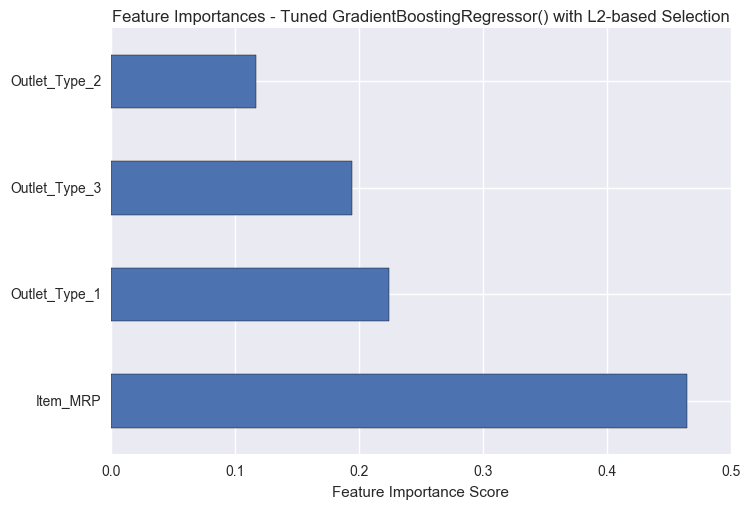

In [41]:
predictors = ['Item_MRP', 'Outlet_Type_1',
       'Outlet_Type_2', 'Outlet_Type_3']
feat_imp = pd.Series(tuned_model.feature_importances_, predictors).sort_values(ascending=False)
feat_imp.plot(kind='barh', title='Feature Importances - Tuned GradientBoostingRegressor() with L2-based Selection')
plt.xlabel('Feature Importance Score')
plt.savefig("feat_imp.png")

C:\Users\DHRUBAJIT\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


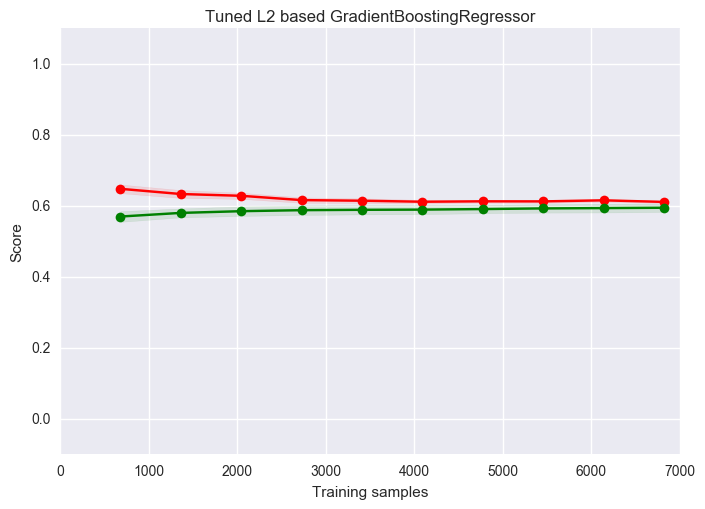

In [40]:
from sklearn.learning_curve import learning_curve
from sklearn.metrics import explained_variance_score, make_scorer
from sklearn.cross_validation import KFold

def plot_curve():
     # fit
    tuned_model.fit(XXX, y)
    train_sizes, train_scores, test_scores = learning_curve(tuned_model, XXX, y, n_jobs=-1, cv=5, train_sizes=np.linspace(.1, 1., 10), verbose=0)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure()
    plt.title("Tuned L2 based GradientBoostingRegressor")
    plt.legend(loc="best")
    plt.xlabel("Training samples")
    plt.ylabel("Score")
    plt.gca().invert_yaxis()
    
    # plot the std deviation as a transparent range at each training set size
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    # plot the average training and test score lines at each training set size
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    # sizes the window for readability and displays the plot
    # shows error from 0 to 1.1
    plt.ylim(-.1,1.1)
    plt.show()

plot_curve()